In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
import holidays
import math

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [4]:
dataset = read_csv("segment_speeds_weather.csv")

In [5]:
dataset = dataset.iloc[: , 1:]

In [6]:
dataset.head(4)

,SegmentId,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday,holiday,Lufttemperatur,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
0,226255131,0,155,2019,91.383333,0,0,0,0,1,0,0,0,13.7,0.0,4.7,0.0,13.7,4.7
1,226255131,1,155,2019,92.000000,0,0,0,0,1,0,0,0,14.1,0.0,5.0,0.0,14.1,5.0
2,226255131,2,155,2019,93.666667,0,0,0,0,1,0,0,0,14.2,0.0,4.8,0.0,14.2,4.8
3,226255131,3,155,2019,86.216667,0,0,0,0,1,0,0,0,14.3,0.0,4.9,0.0,14.3,4.9


In [7]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalizing input features
scaler = MinMaxScaler(feature_range=(1, 18))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.000000,8.172603,1.0,12.246120,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.577778,1.0,5.035354,1.0,11.577778,5.035354
1,0.0,1.739130,8.172603,1.0,12.328160,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.766666,1.0,5.292930,1.0,11.766666,5.292930
2,0.0,2.478261,8.172603,1.0,12.549890,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.813889,1.0,5.121212,1.0,11.813889,5.121212
3,0.0,3.217391,8.172603,1.0,11.558759,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.861111,1.0,5.207071,1.0,11.861111,5.207071


In [8]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [10]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,18)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)','var5(t-1)', 'var6(t-1)', 'var7(t-1)','var8(t-1)','var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)','var17(t-1)','var18(t-1)','var19(t-1)','var1(t)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1         0.0   1.000000   8.172603        1.0  12.246120        1.0   
2         0.0   1.739130   8.172603        1.0  12.328160        1.0   
3         0.0   2.478261   8.172603        1.0  12.549890        1.0   
4         0.0   3.217391   8.172603        1.0  11.558759        1.0   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
id                                                                        
1         1.0        1.0        1.0        18.0         1.0         1.0   
2         1.0        1.0        1.0        18.0         1.0         1.0   
3         1.0        1.0        1.0        18.0         1.0         1.0   
4         1.0        1.0        1.0        18.0         1.0         1.0   

    var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  \
id                                    

In [11]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.75)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [12]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(16164, 1, 19) (16164,) (5387, 1, 19) (5387,)


In [23]:
model_lstm = Sequential()
model_lstm.add(LSTM(512, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=80, return_sequences=True))
model_lstm.add(LSTM(units=80))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 512)            1089536   
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 80)             189760    
_________________________________________________________________
lstm_5 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 1,330,897
Trainable params: 1,330,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=120,validation_data=(test_X, test_y), batch_size=50, shuffle=False)

Epoch 1/120
253/253 [==============================] - 18s 15ms/step - loss: 2.5107 - val_loss: 1.3642
Epoch 2/120
253/253 [==============================] - 2s 10ms/step - loss: 1.2986 - val_loss: 0.8678
Epoch 3/120
253/253 [==============================] - 3s 12ms/step - loss: 1.1425 - val_loss: 0.8160
Epoch 4/120
253/253 [==============================] - 3s 12ms/step - loss: 1.0850 - val_loss: 0.8244
Epoch 5/120
253/253 [==============================] - 3s 11ms/step - loss: 1.0043 - val_loss: 0.8719
Epoch 6/120
253/253 [==============================] - 2s 10ms/step - loss: 0.9419 - val_loss: 0.8723
Epoch 7/120
253/253 [==============================] - 2s 9ms/step - loss: 0.9007 - val_loss: 0.8555
Epoch 8/120
253/253 [==============================] - 2s 9ms/step - loss: 0.8999 - val_loss: 0.8355
Epoch 9/120
253/253 [==============================] - 2s 9ms/step - loss: 0.8819 - val_loss: 0.8323
Epoch 10/120
253/253 [==============================] - 2s 10ms/step - loss: 0.8544 

253/253 [==============================] - 2s 9ms/step - loss: 0.6400 - val_loss: 0.8297
Epoch 82/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6421 - val_loss: 0.8475
Epoch 83/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6365 - val_loss: 0.8640
Epoch 84/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6287 - val_loss: 0.8602
Epoch 85/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6316 - val_loss: 0.8512
Epoch 86/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6308 - val_loss: 0.8554
Epoch 87/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6309 - val_loss: 0.8512
Epoch 88/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6311 - val_loss: 0.8508
Epoch 89/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6265 - val_loss: 0.8675
Epoch 90/120
253/253 [==============================] - 2s 9ms/step - loss: 0.6266 - val_loss: 

In [15]:
pred_y =  model_lstm.predict(test_X)

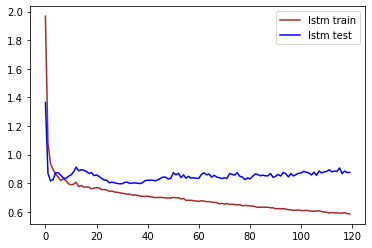

In [16]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [18]:
test_y.reshape(5387,1)

array([[ 4.6060605],
       [ 5.378788 ],
       [ 4.0050507],
       ...,
       [ 7.954546 ],
       [12.848486 ],
       [ 9.929293 ]], dtype=float32)

In [19]:
pred_y

array([[ 4.083146 ],
       [ 4.316552 ],
       [ 5.5694265],
       ...,
       [ 7.183807 ],
       [ 7.653359 ],
       [10.882627 ]], dtype=float32)

1.3352921
0.7853531716375125
1.1555483983401007
0.8748682


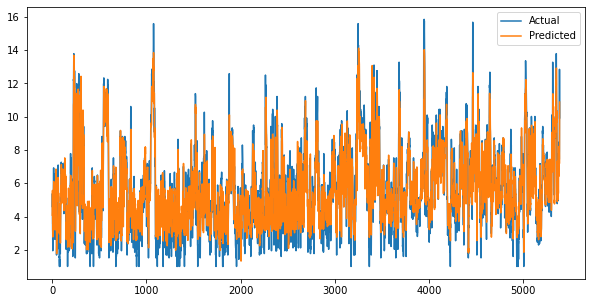

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

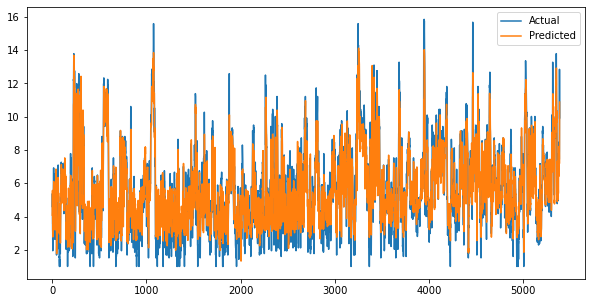

In [21]:
#visualization over full data
tra = test_X
tes = test_y
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

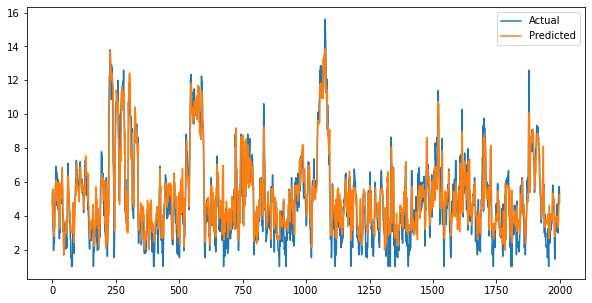

In [22]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()